## HPDM099 lab workforce dynamics and forecast

## Introduction

The purpose of this model is to simulate basic staff-related processes in the context of a clinical lab. Such processes include *workforce demand estimation, recruitment, initial onboarding, competencies training system and leaving*. All the data used in the model is generated based on real-world examples of relevant datasets with a degree of randomness added to make a model more representative and interesting. 

There are three main stocks that gradually flow into one another and form the primary logical chain of the model: <b>workforce demand WD</b>, <b>onboarding workers OW</b> and <b>total staff TS</b>. There is also the competencies part that is calculated outside of the main logic, and forms the fourth stock - <b>workers in training WT</b>.

## Imports

Only the very basic packages were used in the building of this model. It was done purposefully to avoid any confusion, the necessity of installing any supplementary packages, as well as to improve the overall quality of the model.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Model parameters

All parameters are split into sections, from essential ones down to optional.

<b>run_length</b> *(mandatory)* stands for the total runtime of the model.

<b>Initial values</b> *(mandatory)* section allows for manual imputation of initial values across all three main stocks of the model.

<b>seasonal_oscillations_depth</b> *(mandatory, important)* parameter used for the sample data generation. It stands for the volatility of the model data, in other words - how many people will get hired and leave over the runtime. The generated data will have cyclical patterns that are meant to resemble seasonal oscillations of staff count.

<b>recruitment_time</b> *(mandatory)* stands for the mean of a standart distribution from which the samples will be drawn. This is implemented in order to reduce the determinism of the model. The drawn samples are used in the calculation of the flow between the demand and onboarding stocks.        
<b>recruitment_time_std</b> *(mandatory)* standart diviation of the normal distribution.         

<b>training_completion_time</b> *(mandatory)* is used in calculations of the flow between the onboarding and total staff stocks.     

<b>leavers_proc</b> *(optional)* leavers programmed random occurance chance that adds a sense of randomness to the model. It's adjustable by <b>leave_chance</b> and <b>amount_of_leavers</b> and <b>leavers_std</b> which stand for the mean and standart deviation of a normal distribution respectively.          

<b>competencies</b> *(optional)* Whether to include competencies training system (the assumption of the model is that during such training the worker is excluded from the work process, but still counts as a staff member). Competencies run on the basis of the stated number of days required to complete a competency training <b>train_duration</b> and the number of days for which such training is valid <b>decay_duration</b> and needs to be renewed when due. Over the basic run length of the model (1 year) each member of inital staff count will undergo at least 2 competency trainings.

<b>alerts</b> *(optional)* over the runtime of the model, on the basis of generated data, calculates the number of days when the number of competent staff is at a level below <b>staff_threshold</b>. Use <b>notice_time</b> to record such warnings some days in advance of the shortage occurance.

<b>training_acceleration</b> *(optional)* parameter that increases training_completion_time under the condition of total staff number falling below the <b>staff_threshold</b>. The training_completion_time is multiplied by <b>training_rate_multiplier</b>.

<b>reproducible_run</b> *(optional)* is used for generating reproducible results. Set a <b>seed</b> number on the basis of which all random numbers (or distribution samples) will be generated, same results every run.

In [129]:
run_length = 365  # results collection period

initial_demand = 0  # initial value for WD
initial_staff_number = 30  # initial value for TS
initial_trainees_number = 0  # initial value for WO

seasonal_oscillations_depth = 0.003  # seasonal oscillation depth of number of staff (0-1)

recruitment_time = 60  # average number of days to recruit an employee
recruitment_time_std = 7.5  # standard deviation for recruitment time
training_completion_time = 5  # average number of days to onboard an employee

leavers_proc = True  # whether to include randomly occurring leaves
leave_chance = 2.7  # the chances of a random leave every timestep (1-100, %)
amount_of_leavers = 3.5  # amount of leavers per proc of total staff (1-100, %)
leavers_std = 0.8  # standard deviation of leavers per proc of total staff (1-100, %)

training_acceleration = True  # whether to increase training rate if staff N below threshold
staff_threshold = 80  # target for minimal number of staff (1-100, %)
training_rate_multiplier = 2  # training rate multiplier (1-10)

competencies = True  # whether to include competencies training system
train_duration = 3  # N of days employee undergoes training and is excluded from work process
decay_duration = 90  # N of days for complete competency expiration

# whether to include a generation and tracking of alerts
# of predicted competent staff levels falling below the threshold
alerts = True
notice_time = 30  # how much time in advance to produce a warning

# parameters for reproducible runs
reproducible_run = False
seed = 999

## Scenario class

The model consists of two classes - <b>Scenario</b> and <b>LAB</b>.   
    
Scenario class is a "wrapper" for the main logic class, it serves an important function of passing over of all parameters of the model into the LAB class, seeds setting, creating empty data nparrays to store the step-by-step generated time-series data, generating sample data.

In [130]:
class Scenario:
    '''
    Parameter container class for LAB model.
    '''

    def __init__(self, results_collection_period=run_length,
                 leavers_proc=leavers_proc, training_acceleration=training_acceleration,
                 competencies=competencies, warnings=alerts,
                 reproducible_run=reproducible_run, random_number_set=seed):
        '''
        Initialize the Scenario object with default values.

        Parameters:
        ----------
        random_number_set: int, optional
            The random number set to be used by the simulation.
        '''

        # total runtime
        self.runtime = results_collection_period

        # create empty nparrays to store the data
        self.WD = np.zeros(self.runtime,)  # workforce demand
        self.WO = np.zeros(self.runtime,)  # onboarding workers
        self.TS = np.zeros(self.runtime,)  # total staff
        self.WT = np.zeros(self.runtime,)  # workers in competency training

        # set initial values
        self.WD[0] = initial_demand
        self.WO[0] = initial_trainees_number
        self.TS[0] = initial_staff_number

        # set up the BASIC PARAMETERS
        self.recruitment_time = recruitment_time
        self.recruitment_time_std = recruitment_time_std
        self.training_completion_time = training_completion_time

        self.seasonal_oscillations_depth = seasonal_oscillations_depth

        # parameters for TRAINING ACCELERATION
        self.training_acceleration = training_acceleration
        self.staff_threshold = staff_threshold
        self.training_rate_multiplier = training_rate_multiplier

        # parameters for RANDOM LEAVERS
        self.leavers_proc = leavers_proc
        self.leave_chance = leave_chance
        self.amount_of_leavers = amount_of_leavers
        self.leavers_std = leavers_std

        # parameters for COMPETENCIES
        self.competencies = competencies
        self.train_duration = train_duration
        self.decay_duration = decay_duration

        # parameters for WARNINGS
        self.alerts = alerts
        self.notice_time = notice_time
        self.warnings_track = np.zeros(self.runtime,)

        # Sampling
        self.random_number_set = random_number_set
        self.init_sampling()

    def init_sampling(self):
        '''
        Initialize the random number streams and create the distributions/data used by the simulation.
        '''
        if reproducible_run:
            random.seed(self.random_number_set)
            np.random.seed(self.random_number_set)

        # randomly initialize competency status for each employee (0-1)
        self.competencies_status = np.random.uniform(0, 1, int(self.TS[0]))

        # Generate dummy data resembling seasonal staff leaving rate
        # Generate time series data for 365 days
        days = np.arange(1, (self.runtime + 1))

        # Generate seasonal oscillations
        spring = pow((np.sin(2 * np.pi * days / 365) * 3), 2)
        autumn = pow((np.sin(2 * np.pi * (days + 90) / 365) * 3), 2)
        winter = pow((np.sin(2 * np.pi * (days + 180) / 365) * 2), 2)
        summer = pow((np.sin(2 * np.pi * (days + 270) / 365) * 2), 2)

        # Combine the seasonal oscillations
        time_series = spring + autumn + winter + summer

        # rescale the values and produce an array of seasonal leavers counts per day/ LR = leaving rate
        self.LR = (time_series - np.min(time_series)) * \
                  (self.seasonal_oscillations_depth / (np.max(time_series) - np.min(time_series)))


## Lab class

The arguments are inherited from the Scenario class. Several attributes are created to store the metrics. The run function launches the turnover and warnings functions which contain all the main logic of the class. The plot function produces a plot of workforce demand, onboarding, total staff and competent staff dynamics. The last one is designed specifically for the nature of the plotted data, it accepts the "ceil" boolean parameter that makes the data resemble real people counts.

Inside of the turnover function there are competencies, leavers and training acceleration sections that are only activated if the corresponding boolean variables are set to True.

<b>The main stocks calculations are done by the three equations:</b>

The next value for the <b>workforce demand</b>             
is the current value              
*plus* number of staff left from the total staff in this timestep (current total staff minus all staff who stayed after the leaving rate was considered)                             
*minus* current workforce demand multiplied by recruitment rate (the new hirees)          
*plus* random leavers.                                 

<b>Workers onboarding</b> is calculated as            
the current value           
*plus* whoever was recruited (workforce demand multiplied by recruitment rate)                  
*minus* whoever has finished training (currently in onboarding multiplied by current training completion rate).            
The current training completion rate is the same as the basic training_completion_time, unless the training acceleration is on. If so, the training rate will be multiplied by the training rate multiplier

The next value for the <b>total staff</b>            
is the current value            
*minus* number of staff left in this timestep (current total staff minus all staff that stayed after the leaving rate was considered)              
*plus* whoever has finished training (currently in onboarding multiplied by current training completion rate)               
*minus* random leavers.

<b>Competencies</b> are represented as nparray containing values between 0 and 1 that decay every timestep by the value of 1 / training decay. Workers that finished the onboarding process count as fully competent, the value of "1" is appended to the competencies array for every employee who gets transfered from onboarding to total staff stock. Whenever any value of the array reaches 0 or becomes negative, it gets deleted and a "1" is passed to the <b>workers in training (WT)</b> stock. The flow between the competencies array and workers in training stocks is determined by <b>train_duration</b> variable.

On the basis of the total staff and workers in training stocks the <b>warnings</b> are generated, checking for the number of competent workers <b>notice_time</b> timesteps ahead, and witting a value into a nparray each time the number of competent staff falls below the set minimal threshold. As warnings are not continuous data, but a series of points in time, the corresponding values are recorded into separate lists for reproducibility on a plot.                 

<b>Process coverage</b> is calculated as the sum of number of days when there was a sufficient number of competent staff divided by the total runtime of the model.

In [131]:
class LAB:
    '''
    Model of the LAB staff turnover.
    '''

    def __init__(self, args):
        '''
        Constructor

        Parameters:
        ----------
        args: Scenario
            Container class for simulation model inputs
        '''
        self.args = args

        self.runtime = args.runtime
        self.random_number_set = args.random_number_set

        self.WD = args.WD
        self.WO = args.WO
        self.TS = args.TS
        self.WT = args.WT
        self.LR = args.LR

        # Basic parameters
        self.recruitment_time = args.recruitment_time
        self.recruitment_time_std = args.recruitment_time_std
        self.training_completion_time = args.training_completion_time

        self.seasonal_oscillations_depth = args.seasonal_oscillations_depth

        # Training acceleration
        self.training_acceleration = args.training_acceleration
        self.staff_threshold = args.staff_threshold
        self.training_rate_multiplier = args.training_rate_multiplier

        # Random leavers
        self.leavers_proc = args.leavers_proc
        self.leave_chance = args.leave_chance
        self.amount_of_leavers = args.amount_of_leavers
        self.leavers_std = args.leavers_std

        # Competencies
        self.competencies_status = args.competencies_status
        self.competencies = competencies
        self.train_duration = train_duration
        self.decay_duration = decay_duration
        self.new_hirees = 0

        # Warnings
        self.alerts = args.alerts
        self.notice_time = args.notice_time
        self.warnings_track = args.warnings_track

        # Summary metrics
        self.total_hired = 0
        self.total_left = 0
        self.process_coverage = 0
        

    def turnover(self):
        for i in range(self.runtime - 1):

            # Leavers logic
            leavers = 0
            if self.leavers_proc:
                leave_roll = random.randint(1, 10000)
                if leave_roll <= (self.leave_chance * 100):
                    leavers = self.TS[i] - self.TS[i] * \
                        (1 - random.normalvariate(self.amount_of_leavers, self.leavers_std) / 100)

            # Training acceleration logic
            current_training_completion_time = self.training_completion_time
            if self.training_acceleration:
                if self.TS[i] < ((self.WD[0] + self.WO[0] + self.TS[0]) * self.staff_threshold / 100):
                    current_training_completion_time /= self.training_rate_multiplier

            # Main logic
            self.WD[i+1] = self.WD[i] + (self.TS[i] - self.TS[i] * \
                (1 - self.LR[i])) - self.WD[i] * \
            (1 / random.normalvariate(self.recruitment_time, self.recruitment_time_std)) + leavers

            self.WO[i+1] = self.WO[i] + self.WD[i] * \
            (1 / random.normalvariate(self.recruitment_time, self.recruitment_time_std)) - \
                self.WO[i] * (1 / current_training_completion_time)

            self.TS[i+1] = self.TS[i] - (self.TS[i] - self.TS[i] * \
                (1 - self.LR[i])) + self.WO[i] * (1 / current_training_completion_time) - leavers

            # Metrics / total hiree and leavers count
            self.total_hired += self.WO[i] * (1 / current_training_completion_time)
            self.total_left += self.TS[i] - self.TS[i] * (1 - self.LR[i]) + leavers

            # Competencies logic
            if self.competencies:
                self.competencies_status = self.competencies_status - \
                    1 / self.decay_duration

                to_train = 0
                competent_staff = 0
                index = 0
                for competency_status in self.competencies_status:
                    if competency_status <= 0:
                        self.competencies_status = np.delete(
                            self.competencies_status, index)
                        to_train += 1
                    else:
                        competent_staff += 1
                    index += 1

                self.WT[i+1] = self.WT[i] + to_train - \
                    self.WT[i] * (1 / self.train_duration)
                
                self.new_hirees += self.WO[i] * \
                (1 / current_training_completion_time)
                if self.new_hirees >= 1:
                    self.competencies_status = np.append(
                        self.competencies_status, int(self.new_hirees))
                self.new_hirees -= int(self.new_hirees)
                
                if int(self.WT[i+1]) < int(self.WT[i]):
                    self.competencies_status = np.append(
                        self.competencies_status, 1)

    def warnings(self):

        # Warnings logic
        self.x_values = []
        self.y_values = []
        if self.alerts:
            for i in range(self.runtime - self.notice_time - 1):
                u = i + self.notice_time
                predicted_value = self.TS[u] - self.WT[u]
                threshold_value = (self.WD[0] + self.WO[0] + self.TS[0]) * \
                (self.staff_threshold / 100)
                if predicted_value <= threshold_value:
                    self.warnings_track[i] = int(max(self.TS)/2)

                    # Add i to x-coordinates
                    self.x_values.append(i)
                    # Add corresponding y value to y-coordinates
                    self.y_values.append(model.warnings_track[i])
             
            # process coverage
            days_not_covered = np.count_nonzero(self.warnings_track == int(max(self.TS)/2))
            self.process_coverage = (self.runtime - days_not_covered) / self.runtime * 100

    def run(self):

        self.turnover()
        self.warnings()

    def plot_turnover(self, ceil=False):

        plt.figure().set_figwidth(12)
        plt.title("Workforce Dynamics")
        plt.xlabel('Time (days)')
        plt.ylabel('№ of staff')
        plt.grid()
        plt.yticks(np.arange(0.0, max(self.TS)+1, 5.0))
        plt.xticks(np.arange(0, self.runtime, 20.0))
        plt.axhline(y=((self.WD[0] + self.WO[0] + self.TS[0]) * \
                       (self.staff_threshold / 100)), color='tomato', linestyle='--')

        if ceil:
            WDc = np.ceil(self.WD)
            WOc = np.ceil(self.WO)
            TSc = np.ceil(self.TS)

            plt.plot(range(self.runtime), WDc, \
                     color="red", label="Workforce Demand")
            plt.plot(range(self.runtime), WOc, \
                     color="blue", label="Onboarding")
            plt.plot(range(self.runtime), TSc, \
                     color="green", label="Total Staff")

            if self.competencies:
                CWc = np.ceil(self.TS - self.WT)
                plt.plot(range(self.runtime), CWc, \
                         color='gold', label='Competent Workers')
            if self.alerts:
                plt.scatter(self.x_values, self.y_values, \
                            color='black', marker='x', label='Warnings')

        else:
            plt.plot(range(self.runtime), self.WD, \
                     color="red", label="Workforce Demand")
            plt.plot(range(self.runtime), self.WO, \
                     color="blue", label="Onboarding")
            plt.plot(range(self.runtime), self.TS, \
                     color="green", label="Total Staff")

            if self.competencies:
                plt.plot(range(self.runtime), (self.TS - self.WT), color='gold', label='Competent Workers')
            if self.alerts:
                plt.scatter(self.x_values, self.y_values, color='black', marker='x', label='Warnings')

        plt.legend()
        plt.show()
        
    def summary(self):
        if alerts:
            print('Over the runtime of the model, a total of', int(model.total_left), 'employees left,', \
          int(model.total_hired), 'were hired. The process coverage was', round(model.process_coverage, 2), '%.')
        
        else:
            print('Over the runtime of the model, a total of', int(model.total_left), 'employees left,', \
              int(model.total_hired), 'were hired. Set alerts to True to calculate process coverage.')

## Run the model

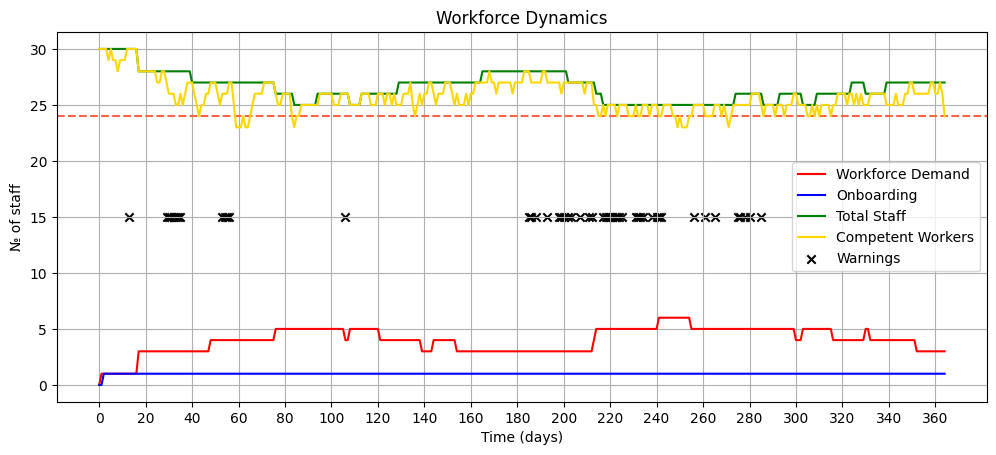

Over the runtime of the model, a total of 24 employees left, 20 were hired. The process coverage was 86.3 %.


In [132]:
leavers_proc = True
training_acceleration = True
competencies = True
alerts = True
reproducible_run = True
run_length = 365
warm_up = 0
seed = 500
'''
def __init__(self, results_collection_period=run_length, warm_up = 0,
                 leavers_proc=leavers_proc, training_acceleration=training_acceleration,
                 competencies=competencies, warnings=alerts,
                 reproducible_run=reproducible_run, random_number_set=seed):
'''
args = Scenario(run_length, leavers_proc, training_acceleration, \
                competencies, alerts, reproducible_run, seed)
model = LAB(args)
model.run()

ceil = True
model.plot_turnover(ceil)
model.summary()

In [70]:
mean = np.mean(model.TS)
mean

26.54697047435232

## Results discussion and conclusion

The model of staff dynamics with elements of forecasting was developed based on the task specification and information obtained from research on clinical lab services and relevant literature addressing similar problems. The model was built from scratch using appropriate techniques and methodology, and the results were presented on the plot along with summary metrics.

The sample data was generated using a series of sinus functions, which are intended to represent averaged seasonal staff turnover. This idea was based on a real-world dataset where such oscillations were observed over a long period of time. Minor adjustments of the seasonal oscillations depth parameter may prove useful in terms significantly affecting the model's output and bringing it to the desired results (not recommended on the first runs).  

In order to <b>run the model</b>, first, set all boolean variables to False. This way you would be able to see the Total Staff, Onboarding and Workforce demand stocks only. Whenever total staff number goes down, the workforce demand rises which is consecutively transformed into onboarding stock. The opposite happens when number of staff increases. After being recruited, the new hirees get added up to the total staff count upon finishing their initial training. The rate of flow between these three initial stocks is determined by mandatory variables for recruitment time, training completion time and their auxillaries.

As values for each stock are calculated in decimals, it is recommended to set ceil value to True to produce a plot closely resembling real people counts.

Next, add random leavers occurence by setting leavers_proc to True. Sudden, unforeseeable and totaly random spikes on the plot will now appear. This feature is implemented to make output look less "mathematical" and create an impression of a real-world dataset.

Training acceleration will not be noticable with default parameters, in order to observe its action the turnover rate has to be increased by increasing the oscillations and leavers parameters. The purpose of this feature is to model the reaction of the HR services to the occuring shortages of staff.

Competencies will generate another stock and plot another line on the plot. As competencies are initialized randomly you may expect the results in the early days to differ significantly from run to run. But as new workers get onboarded and considered by model to be fully competent, and  the trainings system is linear and staff are assumed to be totally compliant, this stock evens out and starts closely following the total staff stock.

Alerts (warnings) will produce a series of dots in the middle of the plot, each standing for the foreseen shortage of staff some time in advance of its occurence. It will also calculate the overall process coverage.

To enhance the representation of the elements of the model, the results on the plot and summary metrics were somewhat hyperbolized. Such initial parameter values were chosen deliberately to maintain simplicity, realism, and adjustability without compromising the overall model structure and logic. By setting the seed value, reproducible results can be generated.

The code organization allows the entire model to be embedded into other frameworks, and it also facilitates the reuse of classes or specific functions.

For further development, the model can be extended to incorporate real-world data, enabling it to produce long-term forecasts and address specific staff-related questions. Additionally, the model can be used to develop efficient HR and training policies, providing valuable insights for general workforce management.

